In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import text
warnings.filterwarnings('ignore')

In [87]:
filepath='data.xlsx'
df = pd.read_excel(filepath)


In [88]:
print(f"\nLoaded {len(df):,} forum posts")
print(f"Date range: {df['created_at'].min().date()} to {df['created_at'].max().date()}")
print(f"Unique users: {df['user_id'].nunique():,}")


Loaded 1,226 forum posts
Date range: 2022-06-27 to 2025-06-06
Unique users: 934


In [89]:
df['year_month'] = df['created_at'].dt.to_period('M')
df

,Unnamed: 0,topic_id,forum_type,raw,user_id,created_at,topic_name,url,like_count,reply_count,reads,word_count,posts_count,num_words,year_month
0,0,24233,Ask a Therapist,my finance feels that i don t love her and tha...,17609,2025-06-06 00:58:09.881,emotionless,https://letstalk.mindline.sg/t/emotionless/24233,0,0,5,1463,2,893,2025-06
1,1,24232,Ask a Therapist,hi i would like some advice on this current si...,19287,2025-06-06 00:55:29.411,how-do-i-better-cope-with-my-negative-thoughts,https://letstalk.mindline.sg/t/how-do-i-better...,0,0,6,972,2,570,2025-06
2,2,24226,Ask a Therapist,i wonder how many people actually ends up star...,15871,2025-06-05 10:14:12.128,is-it-normal-for-hobby-turned-obsession,https://letstalk.mindline.sg/t/is-it-normal-fo...,0,2,37,887,5,121,2025-06
3,3,24220,Ask a Therapist,i liked a girl she nv give a clear response to...,19278,2025-06-05 01:16:39.404,hope-to-cope,https://letstalk.mindline.sg/t/hope-to-cope/24220,0,0,12,271,2,21,2025-06
4,4,24210,Ask a Therapist,for some reason i keep waking up at am in the ...,19274,2025-06-04 10:45:24.356,cant-get-enough-sleep,https://letstalk.mindline.sg/t/cant-get-enough...,0,0,23,709,3,67,2025-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221,1221,398,Ask a Therapist,my actions do not align with how i genuinely f...,97,2022-07-06 05:49:10.735,how-do-i-know-if-i-have-a-mood-disorder,https://letstalk.mindline.sg/t/how-do-i-know-i...,4,0,117,306,2,35,2022-07
1222,1222,397,Ask a Therapist,is it normal for me to hesitate to seek for pr...,82,2022-07-06 05:44:28.220,thinking-about-the-first-step,https://letstalk.mindline.sg/t/thinking-about-...,7,0,73,335,2,88,2022-07
1223,1223,318,Ask a Therapist,how should i cope with social anxiety when i a...,53,2022-07-01 01:05:19.499,i-feel-like-a-burden,https://letstalk.mindline.sg/t/i-feel-like-a-b...,5,1,210,902,5,60,2022-07
1224,1224,312,Ask a Therapist,i realise this sounds ridiculous but my issue ...,64,2022-06-30 04:36:04.695,what-do-i-do-in-between-therapy-sessions,https://letstalk.mindline.sg/t/what-do-i-do-in...,4,0,67,485,2,191,2022-06


In [90]:
# Check forum_type unique values. Drop column since there's only one value.
df['forum_type'].value_counts()
columns_drop = ['Unnamed: 0', 'forum_type']
df.drop(columns=columns_drop, inplace=True)
df.head(10)
print(f" Number of rows in raw df : {len(df)}")

 Number of rows in raw df : 1226


In [91]:
# Check how many days of data captured for each year-month
df['date'] = df['created_at'].dt.date
days_per_month = df.groupby('year_month').agg({'date' : 'nunique', 'topic_id' : 'count', 'created_at' : 'max'}).reset_index()
days_per_month

# Drop 2025-06 data as only 6 days captured and will impact engagement analysis
df_cleaned = df[df['year_month'] != '2025-06']
print(f" Number of rows in cleaned df : {len(df_cleaned)}")

 Number of rows in cleaned df : 1216



Calculating monthly metrics...

✓ Saved: monthly_engagement_trends.png


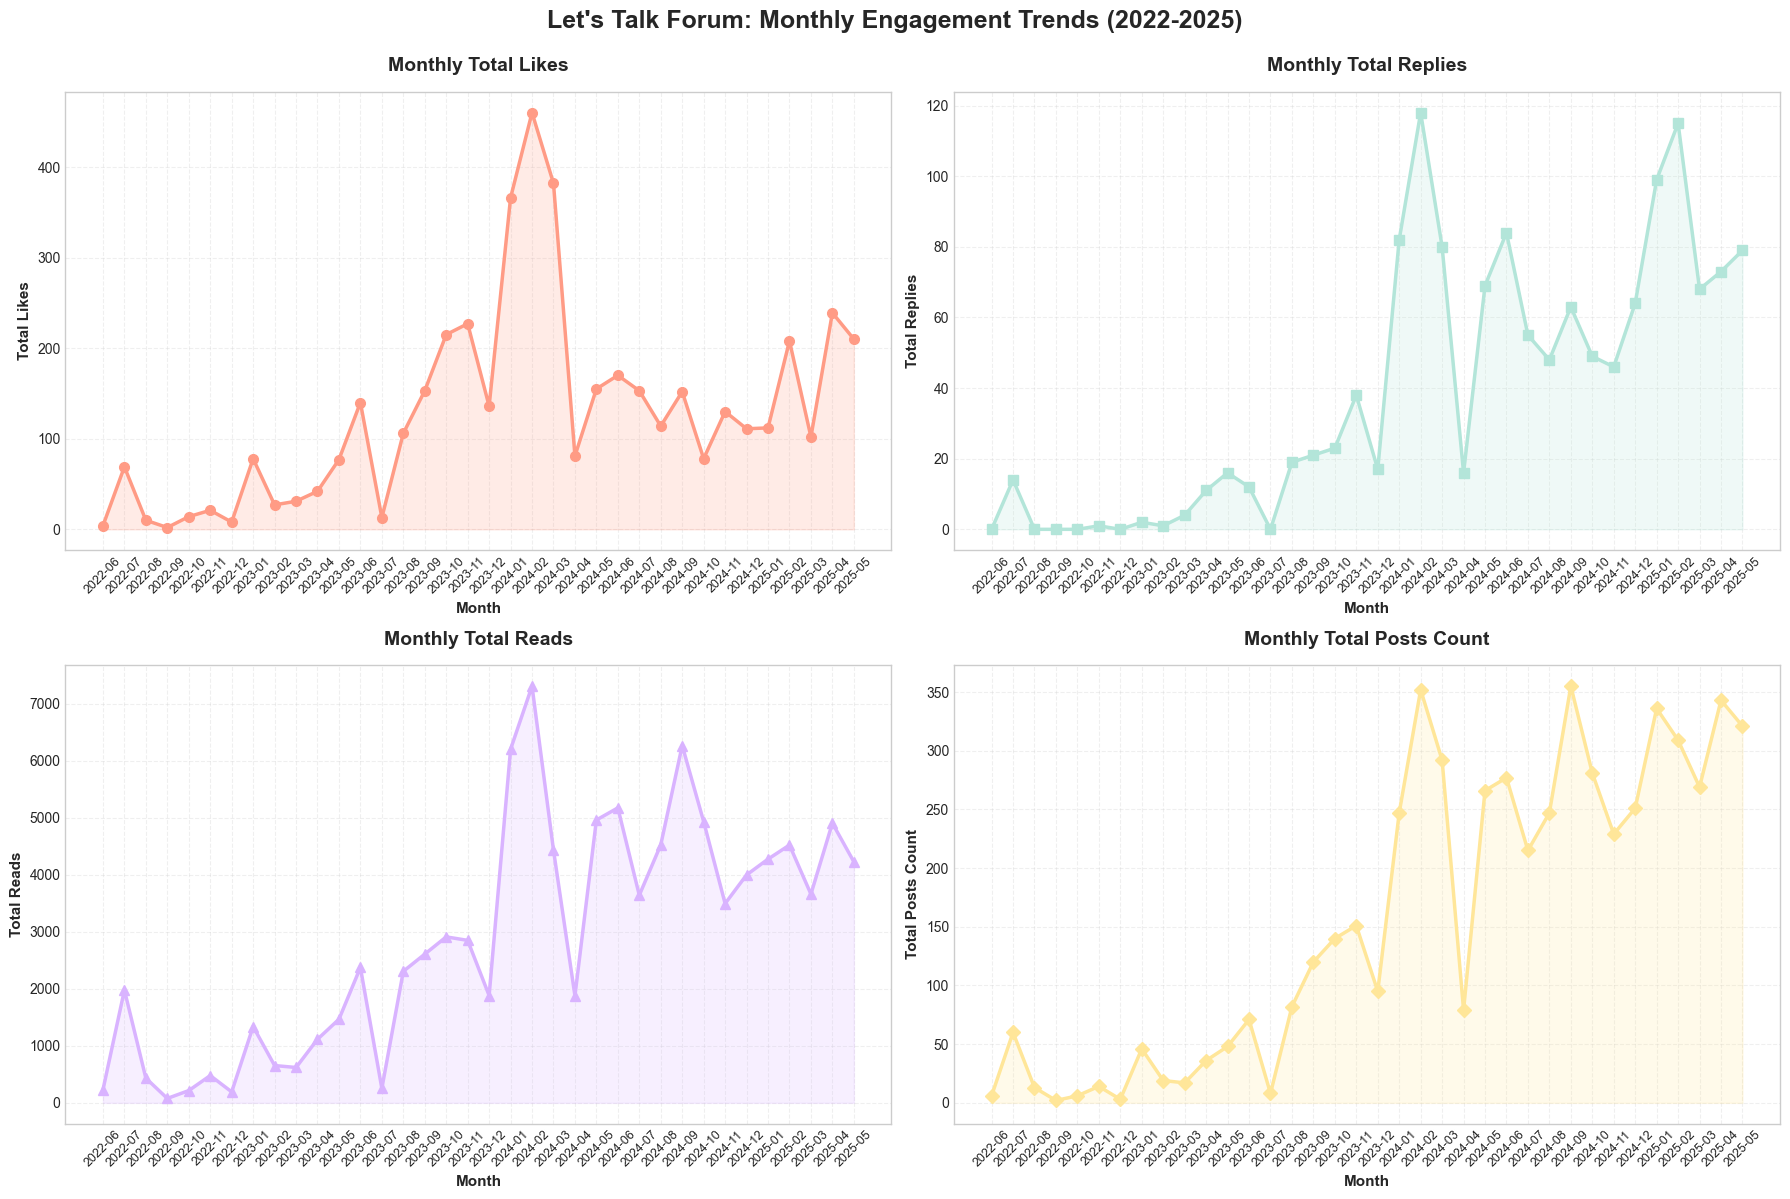

In [92]:

COLORS = {
    'coral': '#FF9B85',
    'mint': '#B3E5D9',
    'lavender': '#D9B3FF',   
    'yellow': '#FFE699',
    'positive': '#4CAF50',
    'negative': '#F44336'
}

# Set style
plt.style.use('seaborn-v0_8-whitegrid')

# Calculate monthly metrics
print("\nCalculating monthly metrics...")

monthly_data = df_cleaned.groupby('year_month').agg({
    'like_count': 'sum',      
    'reply_count': 'sum',     
    'reads': 'sum',           
    'posts_count': 'sum',     
    'topic_id': 'count'       
}).reset_index()

# Rename columns for clarity
monthly_data.columns = ['month', 'total_likes', 'total_replies', 
                        'total_reads', 'total_posts_count', 'number_of_posts']

# Convert period to string for plotting
monthly_data['month_str'] = monthly_data['month'].astype(str)

# CREATE VISUALIZATIONS
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Let\'s Talk Forum: Monthly Engagement Trends (2022-2025)', 
             fontsize=18, fontweight='bold', y=0.995)

# Style parameters
linewidth = 2.5
markersize = 7
alpha_fill = 0.2

# 1. TOTAL LIKES PER MONTH - CORAL
ax1 = axes[0, 0]
ax1.plot(monthly_data['month_str'], monthly_data['total_likes'], 
         marker='o', linewidth=linewidth, markersize=markersize, 
         color=COLORS['coral'], label='Total Likes')
ax1.fill_between(range(len(monthly_data)), monthly_data['total_likes'], 
                 alpha=alpha_fill, color=COLORS['coral'])
ax1.set_title('Monthly Total Likes', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Month', fontsize=11, fontweight='bold')
ax1.set_ylabel('Total Likes', fontsize=11, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.tick_params(axis='x', rotation=45, labelsize=9)
ax1.tick_params(axis='y', labelsize=10)

# 2. TOTAL REPLIES PER MONTH - MINT
ax2 = axes[0, 1]
ax2.plot(monthly_data['month_str'], monthly_data['total_replies'], 
         marker='s', linewidth=linewidth, markersize=markersize, 
         color=COLORS['mint'], label='Total Replies')
ax2.fill_between(range(len(monthly_data)), monthly_data['total_replies'], 
                 alpha=alpha_fill, color=COLORS['mint'])
ax2.set_title('Monthly Total Replies', fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Month', fontsize=11, fontweight='bold')
ax2.set_ylabel('Total Replies', fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.tick_params(axis='x', rotation=45, labelsize=9)
ax2.tick_params(axis='y', labelsize=10)

# 3. TOTAL READS PER MONTH - LAVENDER (PURPLE)
ax3 = axes[1, 0]
ax3.plot(monthly_data['month_str'], monthly_data['total_reads'], 
         marker='^', linewidth=linewidth, markersize=markersize, 
         color=COLORS['lavender'], label='Total Reads')
ax3.fill_between(range(len(monthly_data)), monthly_data['total_reads'], 
                 alpha=alpha_fill, color=COLORS['lavender'])
ax3.set_title('Monthly Total Reads', fontsize=14, fontweight='bold', pad=15)
ax3.set_xlabel('Month', fontsize=11, fontweight='bold')
ax3.set_ylabel('Total Reads', fontsize=11, fontweight='bold')
ax3.grid(True, alpha=0.3, linestyle='--')
ax3.tick_params(axis='x', rotation=45, labelsize=9)
ax3.tick_params(axis='y', labelsize=10)

# 4. TOTAL POSTS_COUNT PER MONTH - YELLOW
ax4 = axes[1, 1]
ax4.plot(monthly_data['month_str'], monthly_data['total_posts_count'], 
         marker='D', linewidth=linewidth, markersize=markersize, 
         color=COLORS['yellow'], label='Total Posts Count')
ax4.fill_between(range(len(monthly_data)), monthly_data['total_posts_count'], 
                 alpha=alpha_fill, color=COLORS['yellow'])
ax4.set_title('Monthly Total Posts Count', fontsize=14, fontweight='bold', pad=15)
ax4.set_xlabel('Month', fontsize=11, fontweight='bold')
ax4.set_ylabel('Total Posts Count', fontsize=11, fontweight='bold')
ax4.grid(True, alpha=0.3, linestyle='--')
ax4.tick_params(axis='x', rotation=45, labelsize=9)
ax4.tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.savefig('monthly_engagement_trends.png', dpi=300, bbox_inches='tight', facecolor='white')
print("\n✓ Saved: monthly_engagement_trends.png")
plt.show()

Saved: all_metrics_combined.png


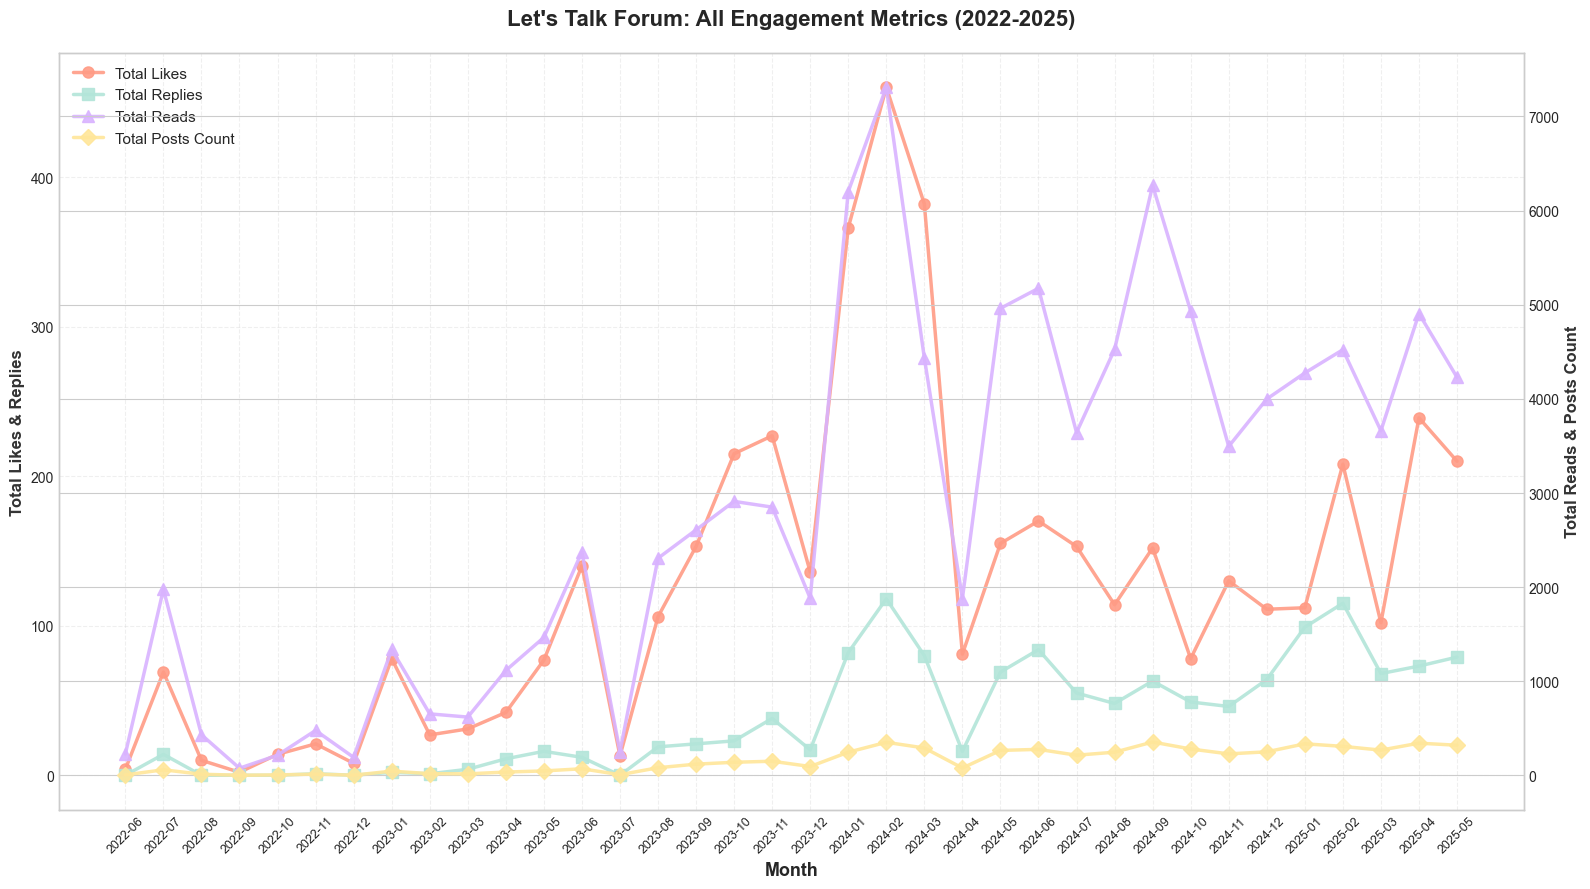


MONTHLY ENGAGEMENT SUMMARY TABLE
month_str  total_likes  total_replies  total_reads  total_posts_count  number_of_posts
  2022-06            4              0          228                  6                2
  2022-07           69             14         1977                 60               17
  2022-08           10              0          432                 13                4
  2022-09            2              0           77                  2                1
  2022-10           14              0          215                  6                3
  2022-11           21              1          478                 14                5
  2022-12            8              0          192                  3                1
  2023-01           78              2         1338                 46               15
  2023-02           27              1          654                 19                6
  2023-03           31              4          620                 17                4
  2023-04

In [93]:
# CREATE COMBINED VIEW

fig, ax = plt.subplots(figsize=(16, 9))

# Normalize data for better visualization (optional - showing actual values)
x = range(len(monthly_data))

# Create twin axes for different scales
ax1 = ax
ax2 = ax1.twinx()

# Plot on primary axis (Likes and Replies - similar scale)
line1 = ax1.plot(monthly_data['month_str'], monthly_data['total_likes'], 
                 marker='o', linewidth=2.5, markersize=8, 
                 color=COLORS['coral'], label='Total Likes', alpha=0.9)
line2 = ax1.plot(monthly_data['month_str'], monthly_data['total_replies'], 
                 marker='s', linewidth=2.5, markersize=8, 
                 color=COLORS['mint'], label='Total Replies', alpha=0.9)

# Plot on secondary axis (Reads and Posts Count - larger scale)
line3 = ax2.plot(monthly_data['month_str'], monthly_data['total_reads'], 
                 marker='^', linewidth=2.5, markersize=8, 
                 color=COLORS['lavender'], label='Total Reads', alpha=0.9)
line4 = ax2.plot(monthly_data['month_str'], monthly_data['total_posts_count'], 
                 marker='D', linewidth=2.5, markersize=8, 
                 color=COLORS['yellow'], label='Total Posts Count', alpha=0.9)

# Labels and title
ax1.set_xlabel('Month', fontsize=13, fontweight='bold')
ax1.set_ylabel('Total Likes & Replies', fontsize=12, fontweight='bold', color='#333')
ax2.set_ylabel('Total Reads & Posts Count', fontsize=12, fontweight='bold', color='#333')
ax1.set_title('Let\'s Talk Forum: All Engagement Metrics (2022-2025)', 
              fontsize=16, fontweight='bold', pad=20)

# Combine legends
lines = line1 + line2 + line3 + line4
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=11, framealpha=0.9)

# Grid and styling
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.tick_params(axis='x', rotation=45, labelsize=9)
ax1.tick_params(axis='y', labelsize=10)
ax2.tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.savefig('all_metrics_combined.png', dpi=300, bbox_inches='tight', facecolor='white')
print("Saved: all_metrics_combined.png")
plt.show()

# SUMMARY TABLE

print("\n" + "="*80)
print("MONTHLY ENGAGEMENT SUMMARY TABLE")
print("="*80)
print(monthly_data[['month_str', 'total_likes', 'total_replies', 
                     'total_reads', 'total_posts_count', 'number_of_posts']].to_string(index=False))


## Y-o-Y Growth Analysis

### 2022 - 2024 Full Year Growth Rate Analysis

YEARLY METRICS SUMMARY
 year  posts  likes  replies  reads  users  avg_likes  avg_replies  avg_reads
 2022     33    128       15   3599     28   3.878788     0.454545 109.060606
 2023    200   1245      164  20378    173   6.225000     0.820000 101.890000
 2024    714   2352      774  56819    562   3.294118     1.084034  79.578431
 2025    269    871      434  21593    214   3.237918     1.613383  80.271375

YEAR-OVER-YEAR GROWTH RATES (%)
      period  posts_growth  likes_growth  replies_growth  reads_growth  users_growth
2022 to 2023    506.060606    872.656250      993.333333    466.212837    517.857143
2023 to 2024    257.000000     88.915663      371.951220    178.825204    224.855491
2024 to 2025    -62.324930    -62.967687      -43.927649    -61.996867    -61.921708
Saved: yearly_trends_with_growth.png


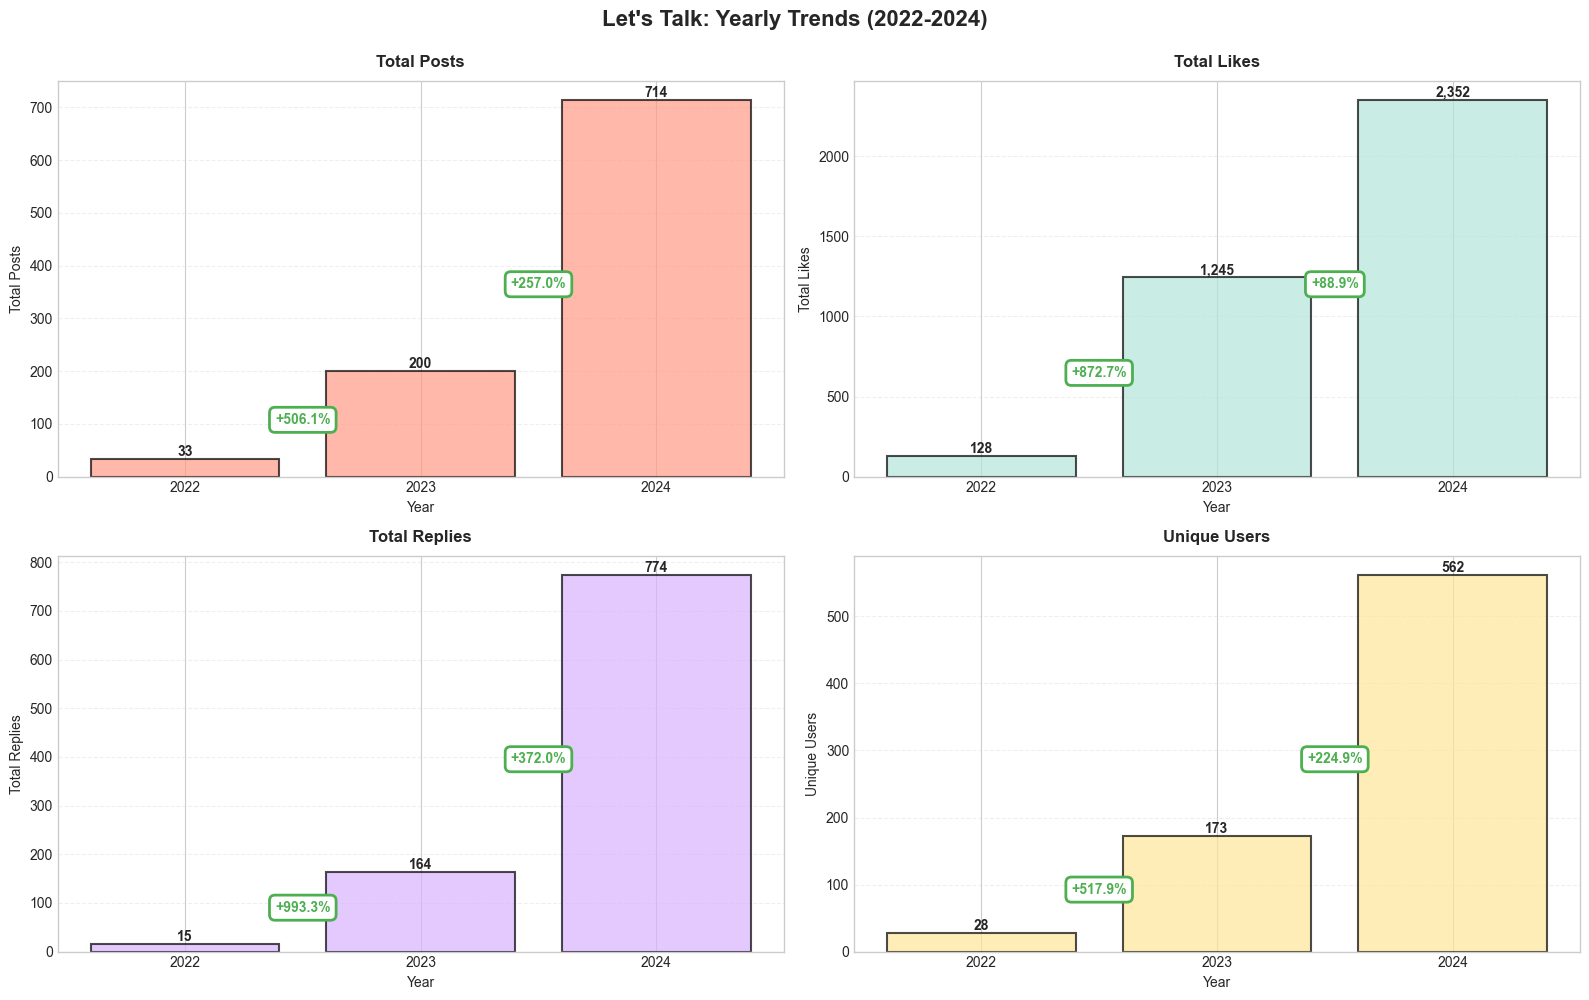


KEY INSIGHTS

 2022 → 2023 (Explosive Growth Phase):
   • Posts increased by 506.1% (33 → 200)
   • Replies surged by 993.3% (15 → 164)
   • User base expanded by 517.9% (28 → 173)

 2023 → 2024 (Sustained Growth Phase):
   • Posts increased by 257.0% (200 → 714)
   • Replies grew by 372.0% (164 → 774)
   • User base grew by 224.9% (173 → 562)

 Overall 2-Year Growth (2022 → 2024):
   • Posts: +2064% (21x growth)
   • Replies: +5,060% (51x growth)
   • Users: +1907% (20x growth)

 Caveat: 2025 data only includes Jan-Jun (partial year)


In [94]:
df_cleaned['year'] = df_cleaned['created_at'].dt.year

# Calculate yearly metrics
yearly = df_cleaned.groupby('year').agg({
    'topic_id': 'count',
    'like_count': 'sum',
    'reply_count': 'sum',
    'reads': 'sum',
    'user_id': 'nunique'
}).reset_index()

yearly.columns = ['year', 'posts', 'likes', 'replies', 'reads', 'users']

# Add per-post averages
yearly['avg_likes'] = df_cleaned.groupby('year')['like_count'].mean().values
yearly['avg_replies'] = df_cleaned.groupby('year')['reply_count'].mean().values
yearly['avg_reads'] = df_cleaned.groupby('year')['reads'].mean().values

print("="*80)
print("YEARLY METRICS SUMMARY")
print("="*80)
print(yearly.to_string(index=False))

# CALCULATE YOY GROWTH RATES

growth = pd.DataFrame()

for i in range(1, len(yearly)):
    curr = yearly.iloc[i]
    # print(curr)
    prev = yearly.iloc[i-1]
    # print(prev)
    
    growth_row = {
        'period': f"{int(prev['year'])} to {int(curr['year'])}",
        'posts_growth': ((curr['posts'] - prev['posts']) / prev['posts'] * 100),
        'likes_growth': ((curr['likes'] - prev['likes']) / prev['likes'] * 100),
        'replies_growth': ((curr['replies'] - prev['replies']) / prev['replies'] * 100),
        'reads_growth': ((curr['reads'] - prev['reads']) / prev['reads'] * 100),
        'users_growth': ((curr['users'] - prev['users']) / prev['users'] * 100)
    }
    growth = pd.concat([growth, pd.DataFrame([growth_row])], ignore_index=True)

print("\n" + "="*80)
print("YEAR-OVER-YEAR GROWTH RATES (%)")
print("="*80)
print(growth.to_string(index=False))


# VISUALIZATION 2: METRIC TRENDS WITH GROWTH ANNOTATIONS

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("Let's Talk: Yearly Trends (2022-2024)", 
             fontsize=16, fontweight='bold', y=0.995)

# Filter to complete years only
yearly_complete = yearly[yearly['year'] <= 2024]

metrics = [
    ('posts', 'Total Posts', COLORS['coral']),
    ('likes', 'Total Likes', COLORS['mint']),
    ('replies', 'Total Replies', COLORS['lavender']),
    ('users', 'Unique Users', COLORS['yellow'])
]

for idx, (metric, title, color) in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    # Bar plot
    bars = ax.bar(yearly_complete['year'], yearly_complete[metric], 
                  color=color, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}', ha='center', va='bottom', 
                fontsize=10, fontweight='bold')
    
    # Add growth rate annotations between bars
    for i in range(1, len(yearly_complete)):
        prev_val = yearly_complete[metric].iloc[i-1]
        curr_val = yearly_complete[metric].iloc[i]
        growth_pct = ((curr_val - prev_val) / prev_val * 100)
        
        # Position between the two bars
        x_pos = yearly_complete['year'].iloc[i-1] + 0.5
        # Place at 50% of the maximum value between the two bars
        y_pos = max(prev_val, curr_val) * 0.5
        
        growth_color = COLORS['positive'] if growth_pct > 0 else COLORS['negative']
        sign = '+' if growth_pct > 0 else ''
        
        ax.annotate(f'{sign}{growth_pct:.1f}%',
                   xy=(x_pos, y_pos), ha='center', fontsize=10,
                   color=growth_color, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                           edgecolor=growth_color, linewidth=2))
    
    ax.set_title(title, fontsize=12, fontweight='bold', pad=10)
    ax.set_xlabel('Year', fontsize=10)
    ax.set_ylabel(title, fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')
    ax.set_xticks(yearly_complete['year'])

plt.tight_layout()
plt.savefig('yearly_trends_with_growth.png', dpi=300, bbox_inches='tight')
print("Saved: yearly_trends_with_growth.png")
plt.show()

# KEY INSIGHTS
print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

# 2022-2023 explosive growth
print("\n 2022 → 2023 (Explosive Growth Phase):")
print(f"   • Posts increased by {growth.iloc[0]['posts_growth']:.1f}% (33 → 200)")
print(f"   • Replies surged by {growth.iloc[0]['replies_growth']:.1f}% (15 → 164)")
print(f"   • User base expanded by {growth.iloc[0]['users_growth']:.1f}% (28 → 173)")

# 2023-2024 sustained growth
print("\n 2023 → 2024 (Sustained Growth Phase):")
print(f"   • Posts increased by {growth.iloc[1]['posts_growth']:.1f}% (200 → 714)")
print(f"   • Replies grew by {growth.iloc[1]['replies_growth']:.1f}% (164 → 774)")
print(f"   • User base grew by {growth.iloc[1]['users_growth']:.1f}% (173 → 562)")

# Overall 2-year growth
two_yr_posts = ((yearly.iloc[2]['posts'] - yearly.iloc[0]['posts']) / yearly.iloc[0]['posts'] * 100)
two_yr_users = ((yearly.iloc[2]['users'] - yearly.iloc[0]['users']) / yearly.iloc[0]['users'] * 100)

print(f"\n Overall 2-Year Growth (2022 → 2024):")
print(f"   • Posts: +{two_yr_posts:.0f}% (21x growth)")
print(f"   • Replies: +5,060% (51x growth)")
print(f"   • Users: +{two_yr_users:.0f}% (20x growth)")

print("\n Caveat: 2025 data only includes Jan-Jun (partial year)")


### 2022 - 2025 Jan to May Growth Rate Analysis


JAN-MAY METRICS COMPARISON (2023-2025)
 year  posts  likes  replies  reads  users  avg_likes  avg_replies  avg_reads
 2023     42    255       34   5193     38   6.071429     0.809524 123.642857
 2024    263   1444      365  24785    220   5.490494     1.387833  94.239544
 2025    269    871      434  21593    214   3.237918     1.613383  80.271375

YEAR-OVER-YEAR GROWTH RATES (%) - JAN-MAY COMPARISON
     period  posts_growth  likes_growth  replies_growth  reads_growth  users_growth
2023 → 2024    526.190476     466.27451      973.529412    377.277104    478.947368
2024 → 2025      2.281369     -39.68144       18.904110    -12.878757     -2.727273

Saved: jan_may_yoy_comparison.png


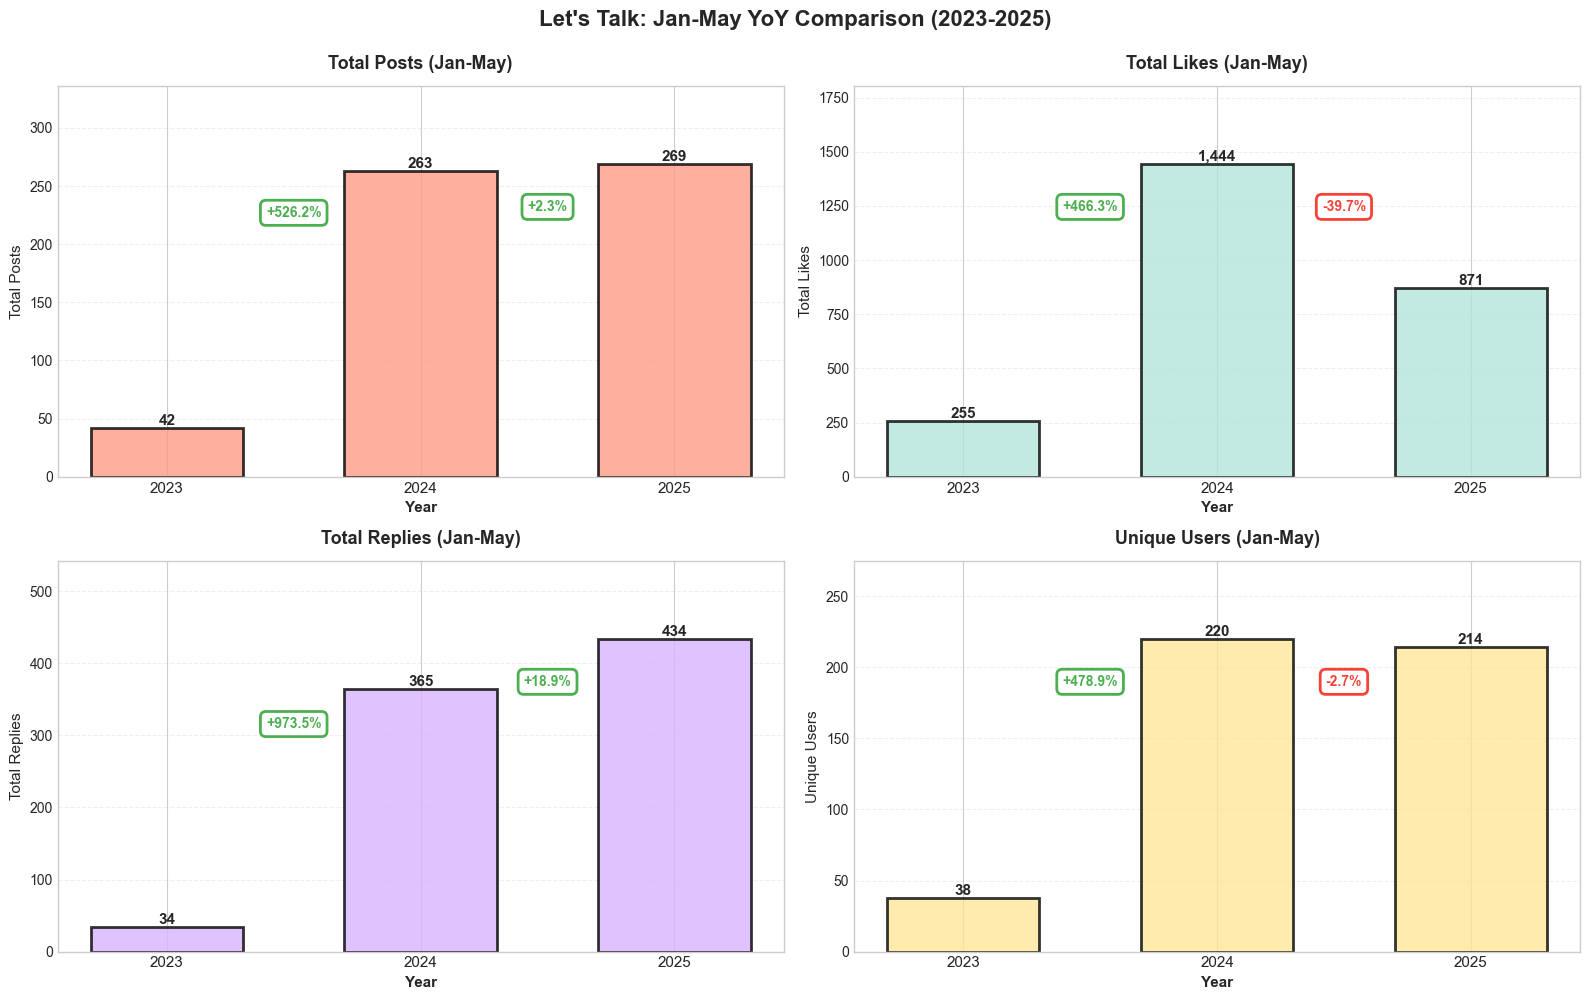

Saved: jan_may_grouped_comparison.png


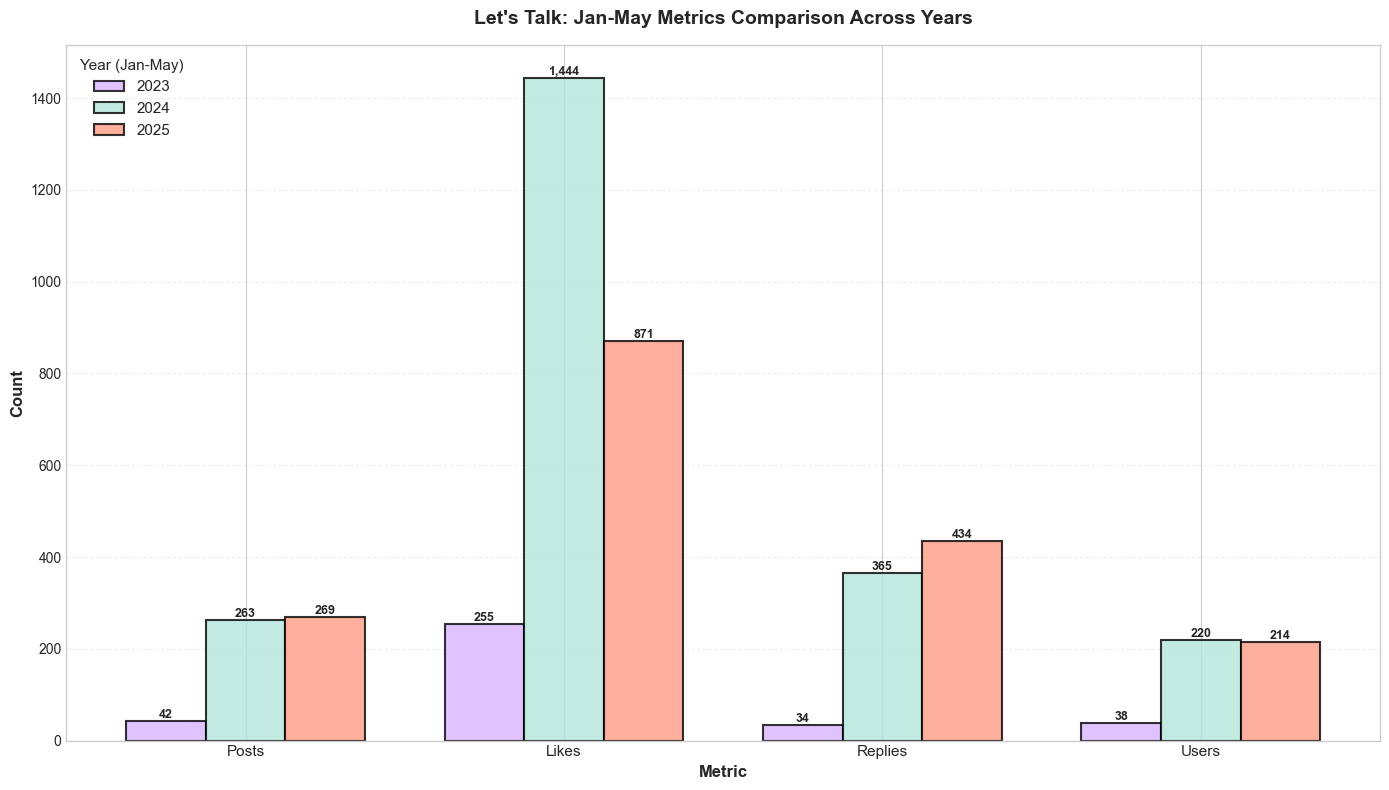


KEY INSIGHTS - JAN-MAY COMPARISON

 2023 to 2024 (Jan-May): Explosive Growth
   • Posts: +526% (42 → 263)
   • Likes: +466% (255 → 1,444)
   • Replies: +974% (34 → 365)
   • Users: +479% (38 → 220)

 2024 to 2025 (Jan-May): Stabilization Phase
   • Posts: +2.3% (263 → 269) - Plateau
   • Likes: -39.7% (1,444 → 871) - Decline
   • Replies: +18.9% (365 → 434) - Still Growing
   • Users: -2.7% (220 → 214) - Stable

 Key Observations:
   • Platform experienced massive growth from 2023 to 2024
   • 2025 shows stabilization with mixed signals:
     - Engagement quality may be shifting (more replies despite fewer likes)
     - User base has plateaued, suggesting market saturation or need for acquisition
     - Content volume remains stable


In [95]:
# Filter for Jan-May only (months 1-5) for fair comparison
df_cleaned['month'] = df_cleaned['created_at'].dt.month
df_jan_may = df_cleaned[df_cleaned['month'].between(1, 5)].copy()


# Calculate yearly metrics for Jan-May period
yearly_jan_may = df_jan_may.groupby('year').agg({
    'topic_id': 'count',
    'like_count': 'sum',
    'reply_count': 'sum',
    'reads': 'sum',
    'user_id': 'nunique'
}).reset_index()

yearly_jan_may.columns = ['year', 'posts', 'likes', 'replies', 'reads', 'users']

# Add per-post averages
yearly_jan_may['avg_likes'] = df_jan_may.groupby('year')['like_count'].mean().values
yearly_jan_may['avg_replies'] = df_jan_may.groupby('year')['reply_count'].mean().values
yearly_jan_may['avg_reads'] = df_jan_may.groupby('year')['reads'].mean().values

print("\n" + "="*80)
print("JAN-MAY METRICS COMPARISON (2023-2025)")
print("="*80)
print(yearly_jan_may.to_string(index=False))

# CALCULATE YOY GROWTH RATES

growth_jan_may = pd.DataFrame()

for i in range(1, len(yearly_jan_may)):
    curr = yearly_jan_may.iloc[i]
    prev = yearly_jan_may.iloc[i-1]
    
    growth_row = {
        'period': f"{int(prev['year'])} → {int(curr['year'])}",
        'posts_growth': ((curr['posts'] - prev['posts']) / prev['posts'] * 100),
        'likes_growth': ((curr['likes'] - prev['likes']) / prev['likes'] * 100),
        'replies_growth': ((curr['replies'] - prev['replies']) / prev['replies'] * 100),
        'reads_growth': ((curr['reads'] - prev['reads']) / prev['reads'] * 100),
        'users_growth': ((curr['users'] - prev['users']) / prev['users'] * 100)
    }
    growth_jan_may = pd.concat([growth_jan_may, pd.DataFrame([growth_row])], ignore_index=True)

print("\n" + "="*80)
print("YEAR-OVER-YEAR GROWTH RATES (%) - JAN-MAY COMPARISON")
print("="*80)
print(growth_jan_may.to_string(index=False))

# VISUALIZATION: JAN-MAY COMPARISON WITH GROWTH ANNOTATIONS

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("Let's Talk: Jan-May YoY Comparison (2023-2025)", 
             fontsize=16, fontweight='bold', y=0.995)

metrics = [
    ('posts', 'Total Posts', COLORS['coral']),
    ('likes', 'Total Likes', COLORS['mint']),
    ('replies', 'Total Replies', COLORS['lavender']),
    ('users', 'Unique Users', COLORS['yellow'])
]

for idx, (metric, title, color) in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    # Bar plot
    x_pos = np.arange(len(yearly_jan_may))
    bars = ax.bar(x_pos, yearly_jan_may[metric], 
                  color=color, alpha=0.8, edgecolor='black', linewidth=2,
                  width=0.6)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}', ha='center', va='bottom', 
                fontsize=11, fontweight='bold')
    
    # Add growth rate annotations between bars
    for i in range(1, len(yearly_jan_may)):
        prev_val = yearly_jan_may[metric].iloc[i-1]
        curr_val = yearly_jan_may[metric].iloc[i]
        growth_pct = ((curr_val - prev_val) / prev_val * 100)
        
        x_pos_arrow = i - 0.5
        y_pos = max(prev_val, curr_val) * 0.85
        
        growth_color = COLORS['positive'] if growth_pct > 0 else COLORS['negative']
        sign = '+' if growth_pct > 0 else ''
        
        ax.annotate(f'{sign}{growth_pct:.1f}%',
                   xy=(x_pos_arrow, y_pos), ha='center', fontsize=10,
                   color=growth_color, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                           edgecolor=growth_color, linewidth=2))
    
    ax.set_title(f"{title} (Jan-May)", fontsize=13, fontweight='bold', pad=12)
    ax.set_xlabel('Year', fontsize=11, fontweight='bold')
    ax.set_ylabel(title, fontsize=11)
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')
    ax.set_xticks(range(len(yearly_jan_may)))
    ax.set_xticklabels(yearly_jan_may['year'].astype(int), fontsize=11)
    ax.set_ylim(0, yearly_jan_may[metric].max() * 1.25)

plt.tight_layout()
plt.savefig('jan_may_yoy_comparison.png', dpi=300, bbox_inches='tight')
print("\nSaved: jan_may_yoy_comparison.png")
plt.show()

# ALTERNATIVE VIEW: SIDE-BY-SIDE COMPARISON

fig, ax = plt.subplots(figsize=(14, 8))

# Prepare data for grouped bar chart
metrics_to_plot = ['posts', 'likes', 'replies', 'users']
metric_labels = ['Posts', 'Likes', 'Replies', 'Users']
x = np.arange(len(metrics_to_plot))
width = 0.25

# Normalize data for better visualization (optional: use actual values)
years = yearly_jan_may['year'].values
colors_by_year = [COLORS['lavender'], COLORS['mint'], COLORS['coral']]

for i, (year, year_color) in enumerate(zip(years, colors_by_year)):
    year_data = yearly_jan_may[yearly_jan_may['year'] == year]
    values = [year_data[m].values[0] for m in metrics_to_plot]
    
    bars = ax.bar(x + i * width, values, width, label=f'{int(year)}',
                  color=year_color, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}', ha='center', va='bottom', 
                fontsize=9, fontweight='bold')

ax.set_xlabel('Metric', fontsize=12, fontweight='bold')
ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.set_title('Let\'s Talk: Jan-May Metrics Comparison Across Years', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x + width)
ax.set_xticklabels(metric_labels, fontsize=11)
ax.legend(title='Year (Jan-May)', fontsize=11, title_fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3, linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('jan_may_grouped_comparison.png', dpi=300, bbox_inches='tight')
print("Saved: jan_may_grouped_comparison.png")
plt.show()


# KEY INSIGHTS

print("\n" + "="*80)
print("KEY INSIGHTS - JAN-MAY COMPARISON")
print("="*80)

print("\n 2023 to 2024 (Jan-May): Explosive Growth")
print(f"   • Posts: +526% (42 → 263)")
print(f"   • Likes: +466% (255 → 1,444)")
print(f"   • Replies: +974% (34 → 365)")
print(f"   • Users: +479% (38 → 220)")

print("\n 2024 to 2025 (Jan-May): Stabilization Phase")
print(f"   • Posts: +2.3% (263 → 269) - Plateau")
print(f"   • Likes: -39.7% (1,444 → 871) - Decline")
print(f"   • Replies: +18.9% (365 → 434) - Still Growing")
print(f"   • Users: -2.7% (220 → 214) - Stable")

print("\n Key Observations:")
print("   • Platform experienced massive growth from 2023 to 2024")
print("   • 2025 shows stabilization with mixed signals:")
print("     - Engagement quality may be shifting (more replies despite fewer likes)")
print("     - User base has plateaued, suggesting market saturation or need for acquisition")
print("     - Content volume remains stable")


## Content Analysis (Pre-defined Key Topics and Common Words Used)

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1226 entries, 0 to 1225
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   topic_id     1226 non-null   int64         
 1   raw          1226 non-null   object        
 2   user_id      1226 non-null   int64         
 3   created_at   1226 non-null   datetime64[ns]
 4   topic_name   1226 non-null   object        
 5   url          1226 non-null   object        
 6   like_count   1226 non-null   int64         
 7   reply_count  1226 non-null   int64         
 8   reads        1226 non-null   int64         
 9   word_count   1226 non-null   int64         
 10  posts_count  1226 non-null   int64         
 11  num_words    1226 non-null   int64         
 12  year_month   1226 non-null   period[M]     
 13  date         1226 non-null   object        
dtypes: datetime64[ns](1), int64(8), object(4), period[M](1)
memory usage: 134.2+ KB



✓ Loaded 1,226 posts

MOST POPULAR TOPICS

📊 Topic Prevalence (% of posts mentioning each topic):

   Relationships              644 posts ( 52.5%) ██████████████████████████
   Seeking Help               547 posts ( 44.6%) ██████████████████████
   Anxiety/Stress             481 posts ( 39.2%) ███████████████████
   Work/Career                437 posts ( 35.6%) █████████████████
   School/Studies             362 posts ( 29.5%) ██████████████
   Depression/Sadness         351 posts ( 28.6%) ██████████████
   Sleep Problems             297 posts ( 24.2%) ████████████
   Self-Worth                 111 posts (  9.1%) ████

TOPICS WITH HIGHEST ENGAGEMENT

💬 Average Engagement by Topic:

Topic                      Avg Likes  Avg Replies   Total Eng.
-----------------------------------------------------------------
School/Studies                  4.26         1.23         5.50
Anxiety/Stress                  4.02         1.37         5.39
Work/Career                     4.05         1.33   

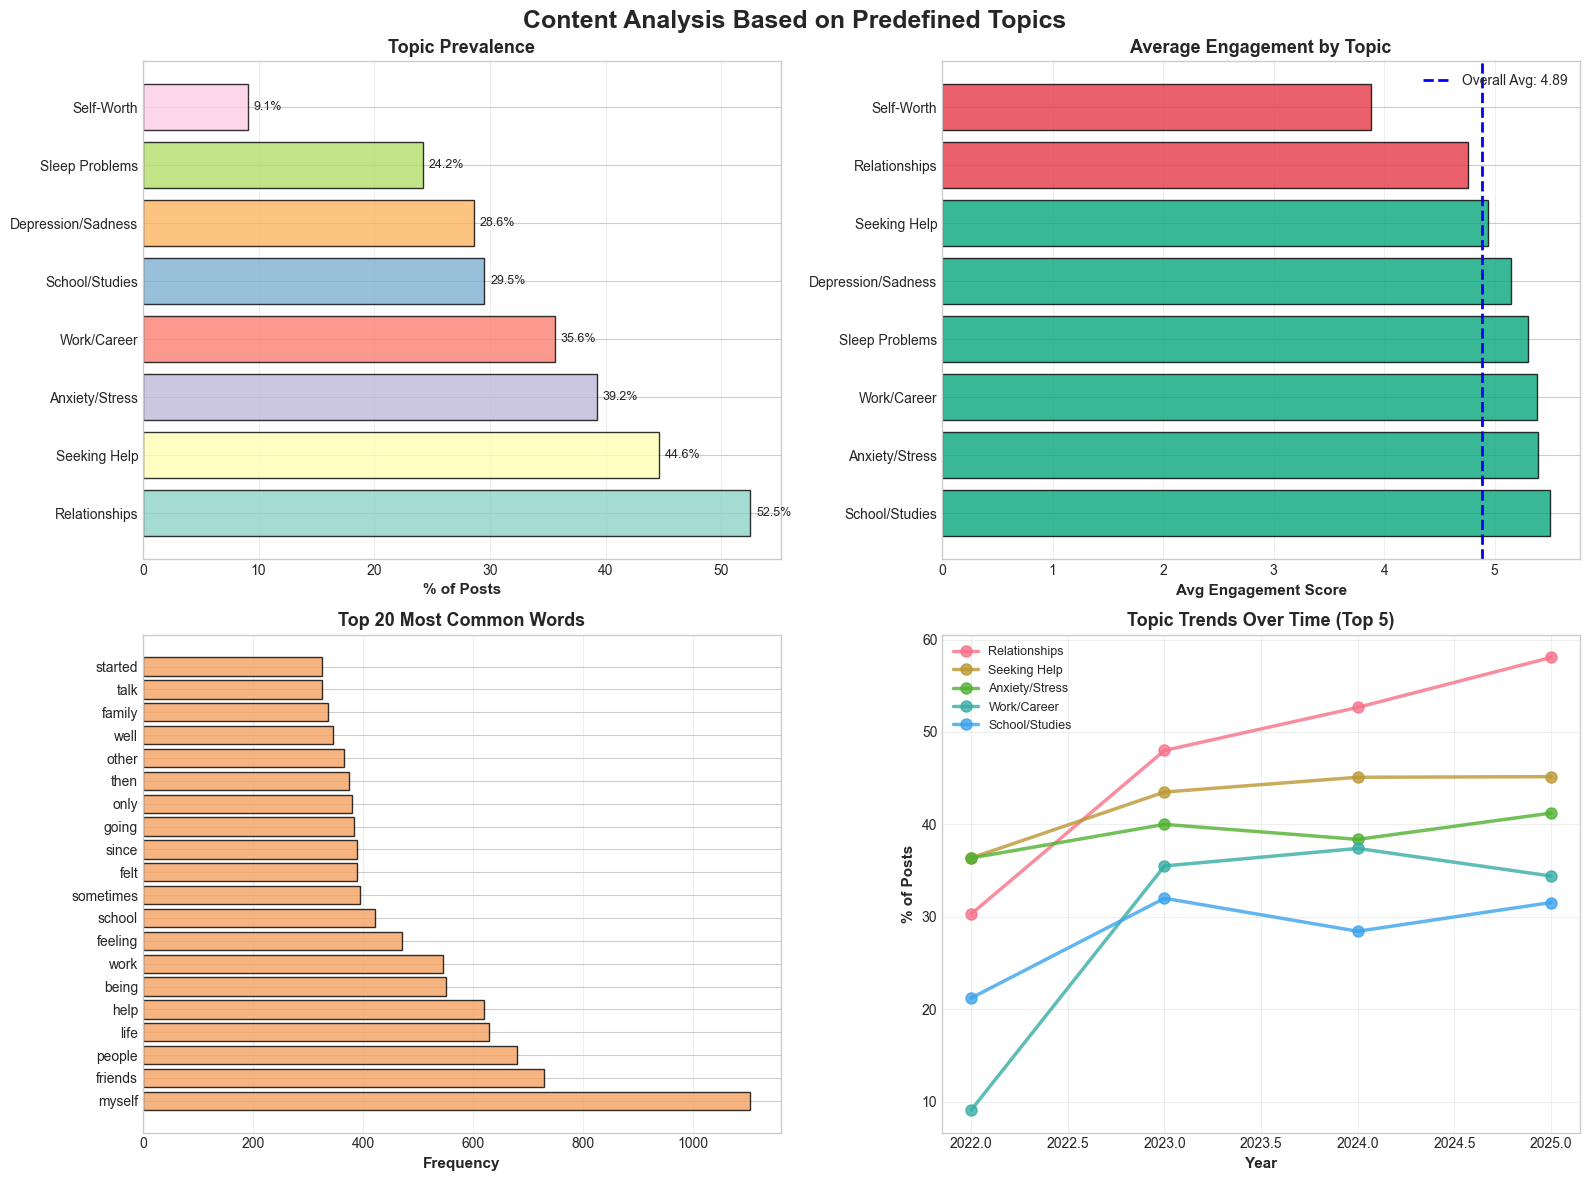

In [98]:
df['year'] = df['created_at'].dt.year
df['engagement_score'] = df['like_count'] + df['reply_count']

print(f"\n✓ Loaded {len(df):,} posts\n")

# 1. SIMPLE KEYWORD SEARCH - What are people talking about?

print("="*80)
print("MOST POPULAR TOPICS")
print("="*80)

# Define simple keyword categories and related words. Can be altered according to domain knowledge
topics = {
    'Anxiety/Stress': ['anxiety', 'anxious', 'stress', 'worry', 'panic', 'nervous'],
    'Depression/Sadness': ['depression', 'depressed', 'sad', 'lonely', 'empty', 'hopeless'],
    'Relationships': ['relationship', 'boyfriend', 'girlfriend', 'friend', 'family', 'parents'],
    'Work/Career': ['work', 'job', 'career', 'boss', 'colleague', 'workplace'],
    'School/Studies': ['school', 'study', 'exam', 'student', 'university', 'college'],
    'Sleep Problems': ['sleep', 'insomnia', 'tired', 'exhausted', 'cant sleep'],
    'Self-Worth': ['confidence', 'insecure', 'worthless', 'hate myself', 'ugly'],
    'Seeking Help': ['help', 'advice', 'therapist', 'counseling', 'support']
}

# Count mentions of each topic
topic_counts = {}
for topic_name, keywords in topics.items():
    pattern = '|'.join(keywords)
    df[f'has_{topic_name}'] = df['raw'].str.contains(pattern, case=False, na=False)
    count = df[f'has_{topic_name}'].sum()
    percentage = (count / len(df)) * 100
    topic_counts[topic_name] = {'count': count, 'percentage': percentage}

# Sort by count
sorted_topics = sorted(topic_counts.items(), key=lambda x: x[1]['count'], reverse=True)

print("\n📊 Topic Prevalence (% of posts mentioning each topic):\n")
for topic, data in sorted_topics:
    bar = '█' * int(data['percentage'] / 2)  # Visual bar
    print(f"   {topic:<25s} {data['count']:>4d} posts ({data['percentage']:>5.1f}%) {bar}")

# 2. WHICH TOPICS GET MORE ENGAGEMENT?


print("\n" + "="*80)
print("TOPICS WITH HIGHEST ENGAGEMENT")
print("="*80)

engagement_by_topic = {}
for topic_name in topics.keys():
    posts_with_topic = df[df[f'has_{topic_name}'] == True]
    if len(posts_with_topic) > 0:
        avg_engagement = posts_with_topic['engagement_score'].mean()
        avg_likes = posts_with_topic['like_count'].mean()
        avg_replies = posts_with_topic['reply_count'].mean()
        engagement_by_topic[topic_name] = {
            'avg_engagement': avg_engagement,
            'avg_likes': avg_likes,
            'avg_replies': avg_replies
        }

# Sort by average engagement
sorted_engagement = sorted(engagement_by_topic.items(), 
                          key=lambda x: x[1]['avg_engagement'], reverse=True)

print("\n💬 Average Engagement by Topic:\n")
print(f"{'Topic':<25s} {'Avg Likes':>10s} {'Avg Replies':>12s} {'Total Eng.':>12s}")
print("-" * 65)
for topic, data in sorted_engagement:
    print(f"{topic:<25s} {data['avg_likes']:>10.2f} {data['avg_replies']:>12.2f} {data['avg_engagement']:>12.2f}")

# Compare to overall average
overall_avg = df['engagement_score'].mean()
print(f"\n{'Overall Average':<25s} {df['like_count'].mean():>10.2f} {df['reply_count'].mean():>12.2f} {overall_avg:>12.2f}")

# 3. MOST COMMON WORDS (Simple frequency count)

print("\n" + "="*80)
print("MOST COMMON WORDS IN POSTS")
print("="*80)

# Combine all text
all_text = ' '.join(df['raw'].astype(str).str.lower())

# Remove common words that don't add meaning
stopwords = ['the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
             'of', 'with', 'is', 'was', 'are', 'been', 'be', 'have', 'has', 'had',
             'do', 'does', 'did', 'will', 'would', 'could', 'should', 'may', 'might',
             'i', 'my', 'me', 'im', 'ive', 'dont', 'cant', 'just', 'really', 'very',
             'like', 'know', 'think', 'feel', 'get', 'go', 'want', 'need', 'make', 
             'always', 'there', 'also', 'from', 'them', 'what', 'because', 'about', 
             'when', 'this', 'that', 'back', 'which', 'some', 'after', 'much', 'still',
             'more', 'they', 'them', 'even', 'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
             'of', 'with', 'is', 'was', 'are', 'been', 'be', 'have', 'has', 'had',
             'do', 'does', 'did', 'will', 'would', 'could', 'should', 'may', 'might',
             'i', 'my', 'me', 'im', 'ive', 'dont', 'cant', 'just', 'really', 'very',
             'like', 'know', 'think', 'feel', 'get', 'go', 'want', 'need', 'make', 
             'always', 'there', 'also', 'from', 'them', 'what', 'because', 'about', 
             'when', 'this', 'that', 'back', 'which', 'some', 'after', 'much', 'still',
             'more', 'they', 'them', 'even', 'im', 'ive', 'dont', 'cant', 'just', 'really', 'very',
    'like', 'know', 'think', 'feel', 'get', 'go', 'want', 'need', 'make', 
    'always', 'there', 'also', 'them', 'back', 'some', 'after', 'much', 'still',
    'more', 'even', 'said', 'tell', 'told', 'asked', 'someone',
    'something', 'things', 'thing', 'time', 'times', 'year', 'years', 'day', 'days', 'don', 'try', 'makes', 've', 'didn', 'lot']



# Extract words
words = re.findall(r'\b[a-z]{4,}\b', all_text)  # Words with 4+ letters
words_filtered = [w for w in words if w not in stopwords]

# Count frequency
word_freq = Counter(words_filtered)
top_50 = word_freq.most_common(50)

print("\n🔤 Top 50 Most Common Words:\n")
for i, (word, count) in enumerate(top_50, 1):
    print(f"   {i:2d}. {word:<20s} ({count:>4d} times)")

# 4. TRENDS OVER TIME


print("\n" + "="*80)
print("TOPIC COMPOSITION OVER TIME")
print("="*80)

# Calculate topic mentions by year
yearly_topics = {}
for year in sorted(df['year'].unique()):
    year_df = df[df['year'] == year]
    yearly_topics[year] = {}
    for topic_name in topics.keys():
        count = year_df[f'has_{topic_name}'].sum()
        pct = (count / len(year_df)) * 100 if len(year_df) > 0 else 0
        yearly_topics[year][topic_name] = pct

print("\n📈 Topic Prevalence by Year (% of posts):\n")
print(f"{'Topic':<25s}", end='')
for year in sorted(yearly_topics.keys()):
    print(f"{year:>10d}", end='')
print()
print("-" * (25 + 10 * len(yearly_topics)))

for topic_name in topics.keys():
    print(f"{topic_name:<25s}", end='')
    for year in sorted(yearly_topics.keys()):
        pct = yearly_topics[year][topic_name]
        print(f"{pct:>9.1f}%", end='')
    print()

# 5. VISUALIZATIONS


fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Content Analysis Based on Predefined Topics', 
             fontsize=18, fontweight='bold')

# 1. Topic Prevalence
ax1 = axes[0, 0]
topic_names = [x[0] for x in sorted_topics]
topic_percentages = [x[1]['percentage'] for x in sorted_topics]
colors = plt.cm.Set3(range(len(topic_names)))
ax1.barh(range(len(topic_names)), topic_percentages, color=colors, alpha=0.8, edgecolor='black')
ax1.set_yticks(range(len(topic_names)))
ax1.set_yticklabels(topic_names, fontsize=10)
ax1.set_xlabel('% of Posts', fontsize=11, fontweight='bold')
ax1.set_title('Topic Prevalence', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
for i, pct in enumerate(topic_percentages):
    ax1.text(pct + 0.5, i, f'{pct:.1f}%', va='center', fontsize=9)

# 2. Engagement by Topic
ax2 = axes[0, 1]
eng_topics = [x[0] for x in sorted_engagement]
eng_scores = [x[1]['avg_engagement'] for x in sorted_engagement]
colors_eng = ['#06A77D' if score > overall_avg else '#E63946' for score in eng_scores]
ax2.barh(range(len(eng_topics)), eng_scores, color=colors_eng, alpha=0.8, edgecolor='black')
ax2.axvline(x=overall_avg, color='blue', linestyle='--', linewidth=2, 
            label=f'Overall Avg: {overall_avg:.2f}')
ax2.set_yticks(range(len(eng_topics)))
ax2.set_yticklabels(eng_topics, fontsize=10)
ax2.set_xlabel('Avg Engagement Score', fontsize=11, fontweight='bold')
ax2.set_title('Average Engagement by Topic', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
ax2.legend()

# 3. Top 20 Words
ax3 = axes[1, 0]
top_20_words = [x[0] for x in top_50[:20]]
top_20_counts = [x[1] for x in top_50[:20]]
ax3.barh(range(len(top_20_words)), top_20_counts, color='#F4A261', alpha=0.8, edgecolor='black')
ax3.set_yticks(range(len(top_20_words)))
ax3.set_yticklabels(top_20_words, fontsize=10)
ax3.set_xlabel('Frequency', fontsize=11, fontweight='bold')
ax3.set_title('Top 20 Most Common Words', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# 4. Topic Trends Over Time (Top 5 topics)
ax4 = axes[1, 1]
top_5_topics = [x[0] for x in sorted_topics[:5]]
for topic in top_5_topics:
    yearly_pcts = [yearly_topics[year][topic] for year in sorted(yearly_topics.keys())]
    ax4.plot(sorted(yearly_topics.keys()), yearly_pcts, 
             marker='o', linewidth=2.5, markersize=8, label=topic, alpha=0.8)
ax4.set_xlabel('Year', fontsize=11, fontweight='bold')
ax4.set_ylabel('% of Posts', fontsize=11, fontweight='bold')
ax4.set_title('Topic Trends Over Time (Top 5)', fontsize=13, fontweight='bold')
ax4.legend(fontsize=9, loc='best')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('simple_content_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
print("\nSaved: simple_content_analysis.png")

print("\n🎯 KEY INSIGHTS:")
print(f"   Most discussed topic: {sorted_topics[0][0]} ({sorted_topics[0][1]['percentage']:.1f}% of posts)")
print(f"   Topic with highest engagement: {sorted_engagement[0][0]} (avg: {sorted_engagement[0][1]['avg_engagement']:.2f})")
print(f"   Most common word: {top_50[0][0]} ({top_50[0][1]} times)")

## Future Work :  Using Latent Dirichlet Allocation to Discover New Topics

In [99]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['year'] = df['created_at'].dt.year

# Clean data
df['raw_clean'] = df['raw'].fillna('').astype(str)
df['topic_name_clean'] = df['topic_name'].fillna('').astype(str)

# ============================================================================
# PART 1: LDA ON POST CONTENT (raw text)
# ============================================================================
print("\n" + "="*80)
print("PART 1: TOPIC MODELING FROM POST CONTENT")
print("="*80)

add_stopwords = ['the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
             'of', 'with', 'is', 'was', 'are', 'been', 'be', 'have', 'has', 'had',
             'do', 'does', 'did', 'will', 'would', 'could', 'should', 'may', 'might',
             'i', 'my', 'me', 'im', 'ive', 'dont', 'cant', 'just', 'really', 'very',
             'like', 'know', 'think', 'feel', 'get', 'go', 'want', 'need', 'make', 
             'always', 'there', 'also', 'from', 'them', 'what', 'because', 'about', 
             'when', 'this', 'that', 'back', 'which', 'some', 'after', 'much', 'still',
             'more', 'they', 'them', 'even', 'im', 'ive', 'dont', 'cant', 'just', 'really', 'very',
    'like', 'know', 'think', 'feel', 'get', 'go', 'want', 'need', 'make', 
    'always', 'there', 'also', 'them', 'back', 'some', 'after', 'much', 'still',
    'more', 'even', 'said', 'tell', 'told', 'asked', 'someone',
    'something', 'things', 'thing', 'time', 'times', 'year', 'years', 'day', 'days', 'don', 'try', 'makes', 've', 'didn', 'lot']

custom_stopwords = list(text.ENGLISH_STOP_WORDS.union(add_stopwords))


# Create document-term matrix
vectorizer_content = CountVectorizer(
    max_df=0.85,              # Ignore terms that appear in >85% of documents
    min_df=5,                 # Ignore terms that appear in <5 documents
    max_features=800,  
    stop_words=custom_stopwords,     # Remove common English words
    ngram_range=(1, 2)        # Include both unigrams and bigrams
)

doc_term_matrix = vectorizer_content.fit_transform(df['raw_clean'])
feature_names = vectorizer_content.get_feature_names_out()

print(f"\n✓ Created document-term matrix: {doc_term_matrix.shape}")
print(f"✓ Vocabulary size: {len(feature_names)} terms")

# Fit LDA model
n_topics_content = 8  # Number of topics to discover
lda_content = LatentDirichletAllocation(
    n_components=n_topics_content,
    max_iter=25,
    learning_method='online',
    random_state=42,
    n_jobs=-1
)

print(f"\n⏳ Fitting LDA model with {n_topics_content} topics...")
lda_content.fit(doc_term_matrix)
print("✓ Model fitted successfully")

# Extract top words for each topic
def get_top_words(model, feature_names, n_words=10):
    """Extract top n words for each topic"""
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[-n_words:][::-1]
        top_words = [feature_names[i] for i in top_indices]
        topics.append(top_words)
    return topics

topics_content = get_top_words(lda_content, feature_names, n_words=15)

# Assign human-readable labels based on top words
topic_labels_content = []
print("\n📊 DISCOVERED TOPICS FROM POST CONTENT:\n")
for i, words in enumerate(topics_content):
    print(f"Topic {i+1}: {', '.join(words[:10])}")
    topic_labels_content.append(f"Topic {i+1}")

# Get topic distribution for each document
doc_topic_dist_content = lda_content.transform(doc_term_matrix)
df['dominant_topic_content'] = doc_topic_dist_content.argmax(axis=1)

# ============================================================================
# PART 2: LDA ON TOPIC NAMES
# ============================================================================
print("\n" + "="*80)
print("PART 2: TOPIC MODELING FROM TOPIC NAMES")
print("="*80)

# Create document-term matrix for topic names
vectorizer_names = CountVectorizer(
    max_df=0.9,
    min_df=2,
    max_features=500,
    stop_words='english',
    ngram_range=(1, 2),
    token_pattern=r'\b[a-z][a-z]+\b'  # At least 2 characters
)

# Topic names are shorter, so we might need different preprocessing
topic_names_matrix = vectorizer_names.fit_transform(df['topic_name_clean'])
feature_names_topics = vectorizer_names.get_feature_names_out()

print(f"\n✓ Created topic names matrix: {topic_names_matrix.shape}")
print(f"✓ Vocabulary size: {len(feature_names_topics)} terms")

# Fit LDA model for topic names
n_topics_names = 6  # Fewer topics since topic names are more concise
lda_names = LatentDirichletAllocation(
    n_components=n_topics_names,
    max_iter=20,
    learning_method='online',
    random_state=42,
    n_jobs=-1
)

print(f"\n⏳ Fitting LDA model with {n_topics_names} topics...")
lda_names.fit(topic_names_matrix)
print("✓ Model fitted successfully")

topics_names = get_top_words(lda_names, feature_names_topics, n_words=12)

print("\n📊 DISCOVERED TOPICS FROM TOPIC NAMES:\n")
topic_labels_names = []
for i, words in enumerate(topics_names):
    print(f"Topic {i+1}: {', '.join(words[:8])}")
    topic_labels_names.append(f"Topic {i+1}")

doc_topic_dist_names = lda_names.transform(topic_names_matrix)
df['dominant_topic_names'] = doc_topic_dist_names.argmax(axis=1)

# ============================================================================
# ANALYZE TOPIC DISTRIBUTIONS
# ============================================================================
print("\n" + "="*80)
print("TOPIC DISTRIBUTION ANALYSIS")
print("="*80)

# Count posts per topic (content-based)
topic_counts_content = df['dominant_topic_content'].value_counts().sort_index()
print("\n📈 Post Distribution - Content Topics:")
for topic_id, count in topic_counts_content.items():
    pct = (count / len(df)) * 100
    print(f"   Topic {topic_id+1}: {count:4d} posts ({pct:5.1f}%)")

# Count posts per topic (name-based)
topic_counts_names = df['dominant_topic_names'].value_counts().sort_index()
print("\n📈 Post Distribution - Topic Name Categories:")
for topic_id, count in topic_counts_names.items():
    pct = (count / len(df)) * 100
    print(f"   Topic {topic_id+1}: {count:4d} posts ({pct:5.1f}%)")

# ============================================================================
# ENGAGEMENT ANALYSIS BY TOPIC
# ============================================================================
print("\n" + "="*80)
print("ENGAGEMENT BY DISCOVERED TOPICS")
print("="*80)

df['engagement_score'] = df['like_count'] + df['reply_count']

# Content topics
print("\n💬 Average Engagement - Content Topics:\n")
print(f"{'Topic':<15s} {'Avg Likes':>12s} {'Avg Replies':>12s} {'Avg Reads':>12s} {'Total Eng.':>12s}")
print("-" * 65)

for topic_id in range(n_topics_content):
    topic_posts = df[df['dominant_topic_content'] == topic_id]
    if len(topic_posts) > 0:
        avg_likes = topic_posts['like_count'].mean()
        avg_replies = topic_posts['reply_count'].mean()
        avg_reads = topic_posts['reads'].mean()
        avg_eng = topic_posts['engagement_score'].mean()
        print(f"Topic {topic_id+1:<8d} {avg_likes:>12.2f} {avg_replies:>12.2f} {avg_reads:>12.2f} {avg_eng:>12.2f}")

overall_avg_eng = df['engagement_score'].mean()
print(f"\n{'Overall Average':<15s} {df['like_count'].mean():>12.2f} {df['reply_count'].mean():>12.2f} {df['reads'].mean():>12.2f} {overall_avg_eng:>12.2f}")

# Topic names
print("\n💬 Average Engagement - Topic Name Categories:\n")
print(f"{'Topic':<15s} {'Avg Likes':>12s} {'Avg Replies':>12s} {'Avg Reads':>12s} {'Total Eng.':>12s}")
print("-" * 65)

for topic_id in range(n_topics_names):
    topic_posts = df[df['dominant_topic_names'] == topic_id]
    if len(topic_posts) > 0:
        avg_likes = topic_posts['like_count'].mean()
        avg_replies = topic_posts['reply_count'].mean()
        avg_reads = topic_posts['reads'].mean()
        avg_eng = topic_posts['engagement_score'].mean()
        print(f"Topic {topic_id+1:<8d} {avg_likes:>12.2f} {avg_replies:>12.2f} {avg_reads:>12.2f} {avg_eng:>12.2f}")


print("\n" + "="*80)
print("✅ LDA ANALYSIS COMPLETE!")
print("="*80)
print(f"\n🎯 KEY FINDINGS:")
print(f"   • Discovered {n_topics_content} topics from post content")
print(f"   • Discovered {n_topics_names} categories from topic names")
print(f"   • Most common content topic: Topic {topic_counts_content.idxmax() + 1} "
      f"({(topic_counts_content.max() / len(df)) * 100:.1f}% of posts)")
print(f"   • Most common topic name category: Topic {topic_counts_names.idxmax() + 1} "
      f"({(topic_counts_names.max() / len(df)) * 100:.1f}% of posts)")

print("\n💡 INTERPRETATION GUIDE:")
print("   • Content topics reveal WHAT users actually write about")
print("   • Topic name categories show HOW users frame their concerns")
print("   • Compare engagement across topics to find what resonates most")
print("   • Use this to guide content moderation and support resources")


PART 1: TOPIC MODELING FROM POST CONTENT

✓ Created document-term matrix: (1226, 800)
✓ Vocabulary size: 800 terms

⏳ Fitting LDA model with 8 topics...
✓ Model fitted successfully

📊 DISCOVERED TOPICS FROM POST CONTENT:

Topic 1: normal, panic, anxiety, feels, thoughts, attacks, nervous, feelings, attack, feeling
Topic 2: relationship, partner, friend, months, ex, guy, love, boyfriend, got, friends
Topic 3: self, harm, self harm, sex, having, bf, plus, fear, okay, stress
Topic 4: sister, life, school, hair, elder, watching, friends, college, family, grades
Topic 5: work, job, help, anxiety, mental, health, doing, working, hard, getting
Topic 6: parents, sleep, home, mom, feeling, dad, life, going, eat, stop
Topic 7: people, life, friends, help, way, feeling, talk, thoughts, bad, hate
Topic 8: friends, felt, school, started, got, close, people, friend, talk, say

PART 2: TOPIC MODELING FROM TOPIC NAMES

✓ Created topic names matrix: (1226, 500)
✓ Vocabulary size: 500 terms

⏳ Fitting 

## LDA on Raw Content

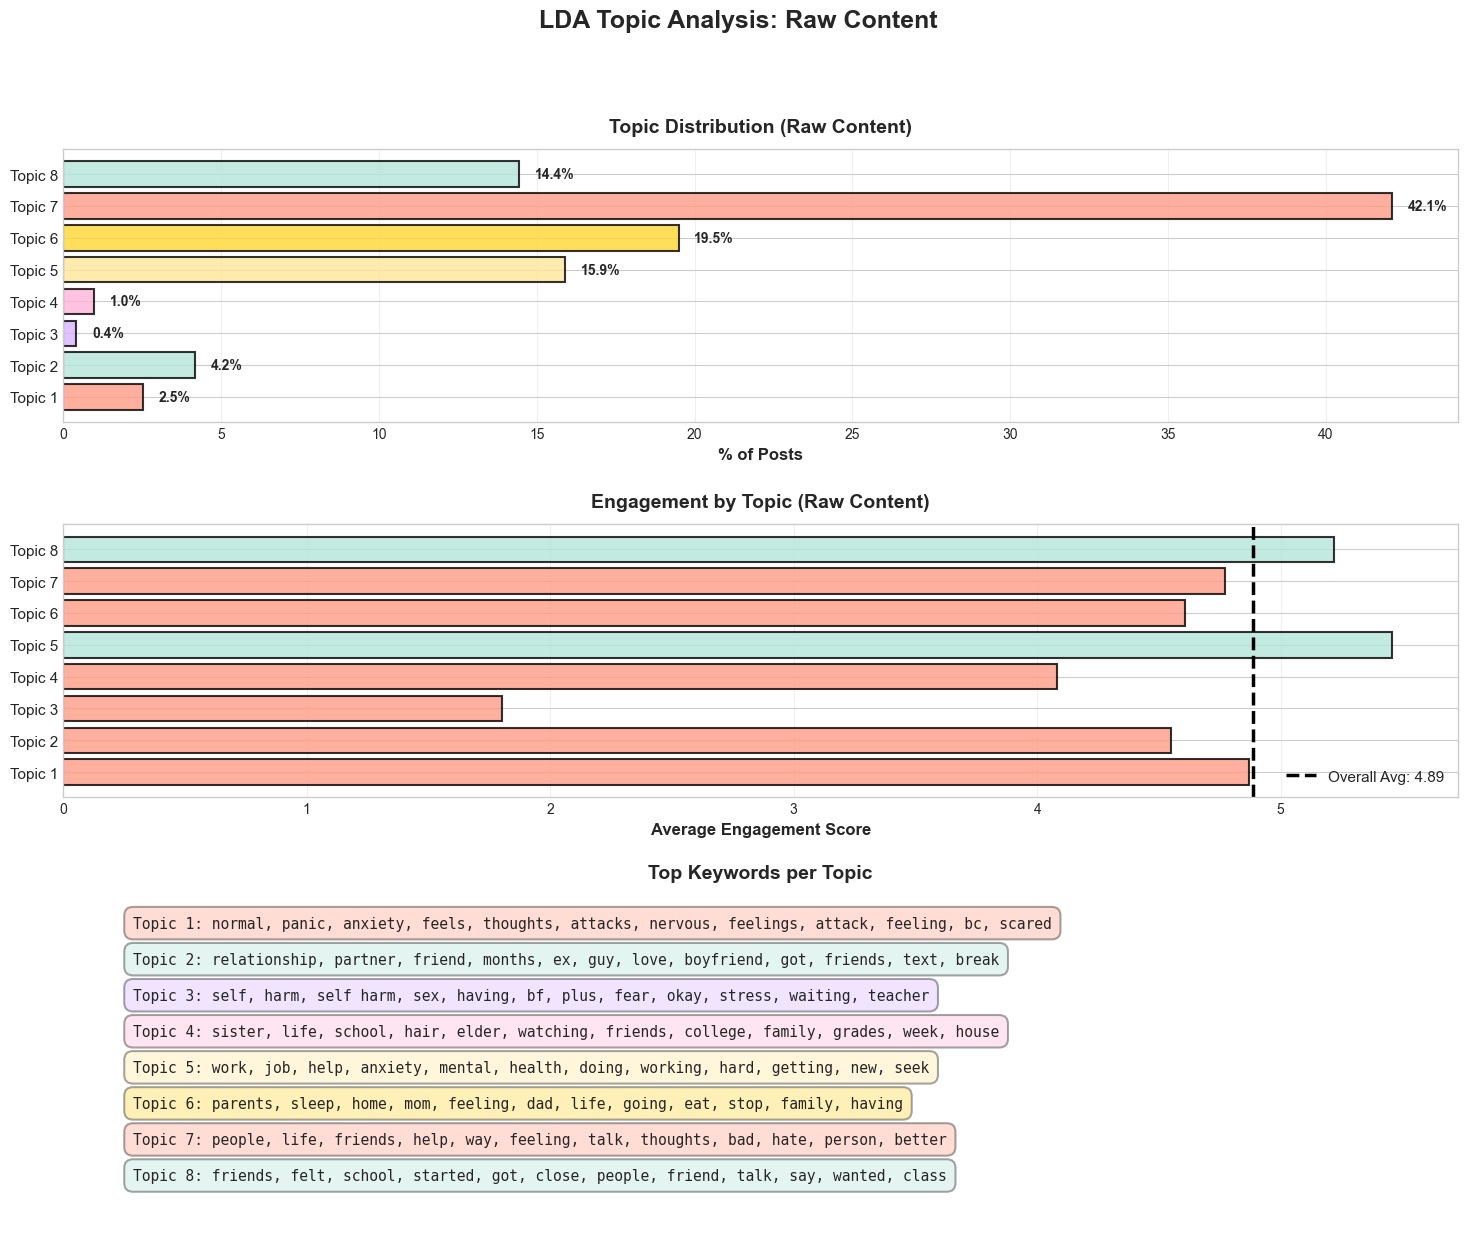

In [100]:
COLORS = {
    'coral': '#FF9B85',
    'mint': '#B3E5D9',
    'lavender': '#D9B3FF',
    'pink': '#FFB3D9',
    'yellow': '#FFE699',
    'accent': '#FFD633'
}

PALETTE = [COLORS['coral'], COLORS['mint'], COLORS['lavender'], 
           COLORS['pink'], COLORS['yellow'], COLORS['accent']]

# VISUALIZATION 1: RAW CONTENT TOPICS


fig1 = plt.figure(figsize=(18, 14))
gs1 = fig1.add_gridspec(3, 1, hspace=0.35, height_ratios=[1, 1, 1.2])

fig1.suptitle("LDA Topic Analysis: Raw Content", 
              fontsize=18, fontweight='bold', y=0.98)

# 1A. Topic Distribution - Raw Content
ax1 = fig1.add_subplot(gs1[0])
topic_pcts_content = [(count / len(df)) * 100 for count in topic_counts_content]
bars1 = ax1.barh(range(len(topic_counts_content)), topic_pcts_content, 
                 color=PALETTE[:len(topic_counts_content)], alpha=0.8, 
                 edgecolor='black', linewidth=1.5)
ax1.set_yticks(range(len(topic_counts_content)))
ax1.set_yticklabels([f"Topic {i+1}" for i in range(len(topic_counts_content))], fontsize=11)
ax1.set_xlabel('% of Posts', fontsize=12, fontweight='bold')
ax1.set_title('Topic Distribution (Raw Content)', fontsize=14, fontweight='bold', pad=12)
ax1.grid(True, alpha=0.3, axis='x')
for i, pct in enumerate(topic_pcts_content):
    ax1.text(pct + 0.5, i, f'{pct:.1f}%', va='center', fontsize=10, fontweight='bold')

# 1B. Engagement by Raw Content Topic
ax2 = fig1.add_subplot(gs1[1])
engagement_content = []
for topic_id in range(n_topics_content):
    topic_posts = df[df['dominant_topic_content'] == topic_id]
    if len(topic_posts) > 0:
        engagement_content.append(topic_posts['engagement_score'].mean())
    else:
        engagement_content.append(0)

colors_eng_content = [COLORS['mint'] if eng > overall_avg_eng else COLORS['coral'] 
                      for eng in engagement_content]
bars2 = ax2.barh(range(n_topics_content), engagement_content,
                 color=colors_eng_content, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.axvline(x=overall_avg_eng, color='black', linestyle='--', linewidth=2.5, 
            label=f'Overall Avg: {overall_avg_eng:.2f}')
ax2.set_yticks(range(n_topics_content))
ax2.set_yticklabels([f"Topic {i+1}" for i in range(n_topics_content)], fontsize=11)
ax2.set_xlabel('Average Engagement Score', fontsize=12, fontweight='bold')
ax2.set_title('Engagement by Topic (Raw Content)', fontsize=14, fontweight='bold', pad=12)
ax2.grid(True, alpha=0.3, axis='x')
ax2.legend(fontsize=11, loc='lower right')

# 1C. Top Words per Raw Content Topic
ax3 = fig1.add_subplot(gs1[2])
ax3.axis('off')
ax3.set_title('Top Keywords per Topic', fontsize=14, fontweight='bold', pad=15)

y_pos = 0.95
for i, words in enumerate(topics_content):
    topic_text = f"Topic {i+1}: " + ", ".join(words[:12])
    ax3.text(0.05, y_pos, topic_text, fontsize=10.5, 
            bbox=dict(boxstyle='round,pad=0.6', facecolor=PALETTE[i % len(PALETTE)], 
                     alpha=0.35, edgecolor='black', linewidth=1.5),
            verticalalignment='top', family='monospace')
    y_pos -= 0.11

plt.savefig('lda_raw_content_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

## LDA on Topic Names

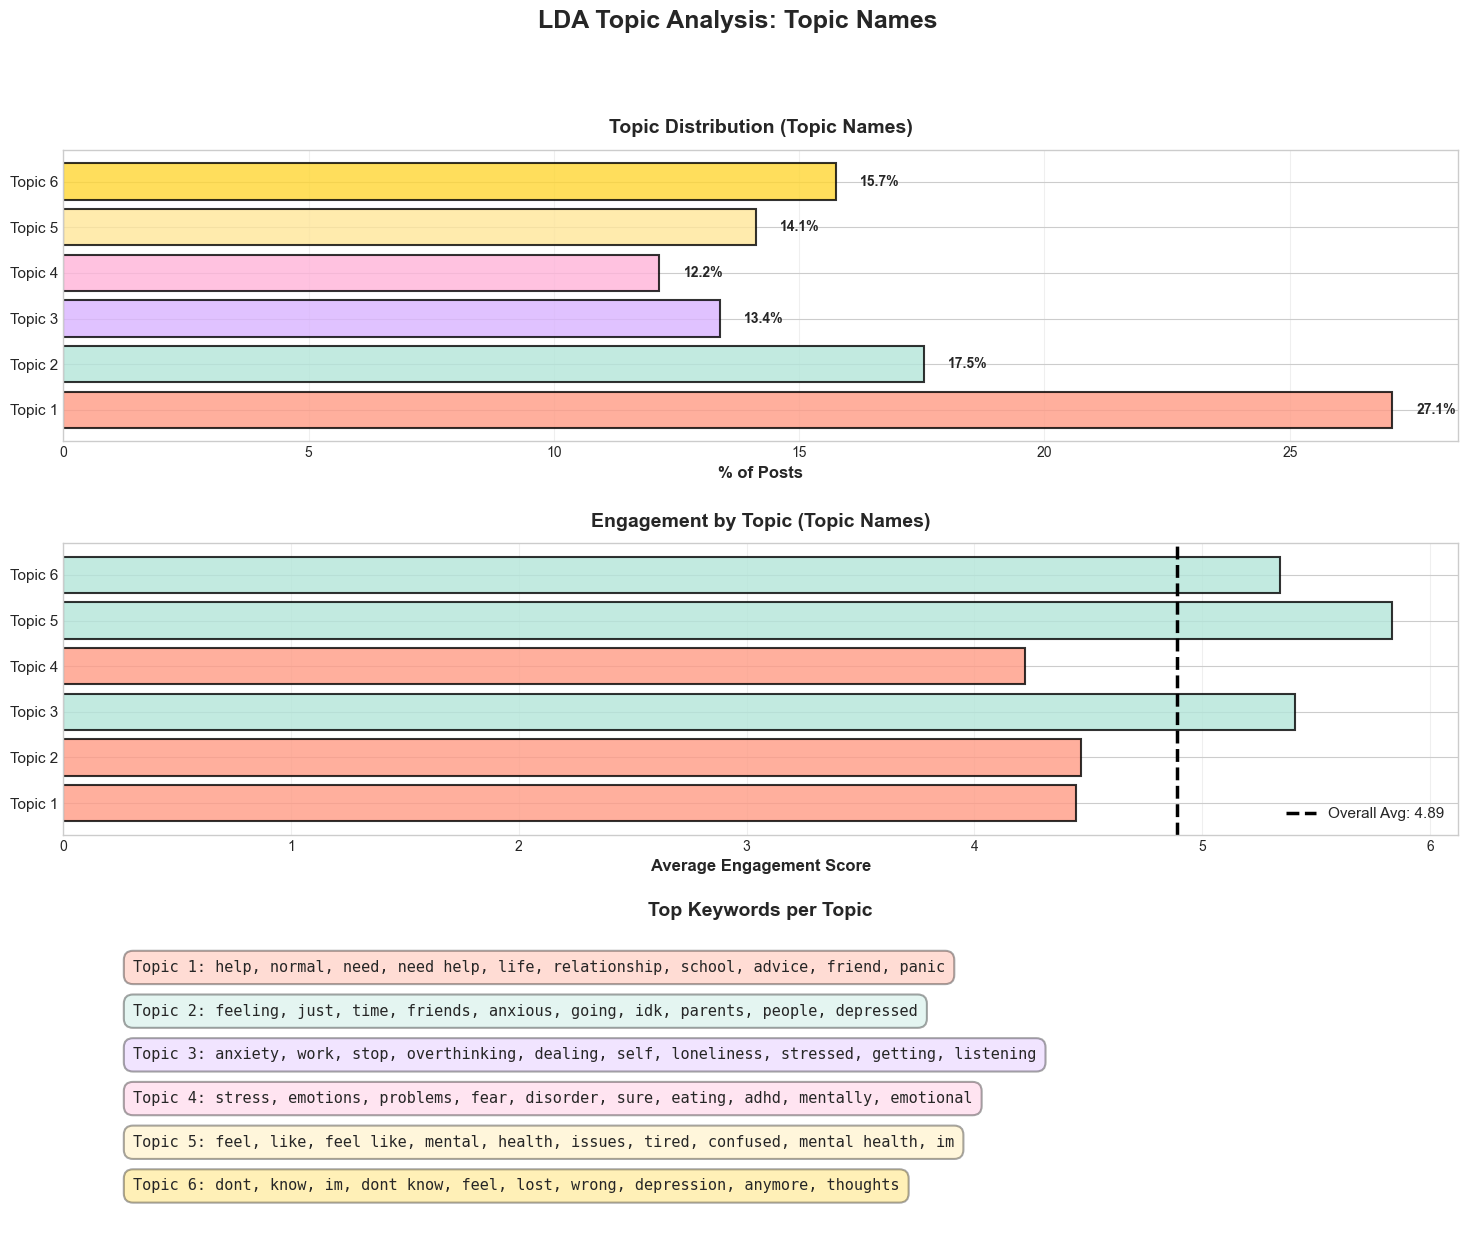

In [101]:

fig2 = plt.figure(figsize=(18, 14))
gs2 = fig2.add_gridspec(3, 1, hspace=0.35, height_ratios=[1, 1, 1])

fig2.suptitle("LDA Topic Analysis: Topic Names", 
              fontsize=18, fontweight='bold', y=0.98)

# 2A. Topic Distribution - Topic Names
ax4 = fig2.add_subplot(gs2[0])
topic_pcts_names = [(count / len(df)) * 100 for count in topic_counts_names]
bars3 = ax4.barh(range(len(topic_counts_names)), topic_pcts_names,
                 color=PALETTE[:len(topic_counts_names)], alpha=0.8, 
                 edgecolor='black', linewidth=1.5)
ax4.set_yticks(range(len(topic_counts_names)))
ax4.set_yticklabels([f"Topic {i+1}" for i in range(len(topic_counts_names))], fontsize=11)
ax4.set_xlabel('% of Posts', fontsize=12, fontweight='bold')
ax4.set_title('Topic Distribution (Topic Names)', fontsize=14, fontweight='bold', pad=12)
ax4.grid(True, alpha=0.3, axis='x')
for i, pct in enumerate(topic_pcts_names):
    ax4.text(pct + 0.5, i, f'{pct:.1f}%', va='center', fontsize=10, fontweight='bold')

# 2B. Engagement by Topic Names
ax5 = fig2.add_subplot(gs2[1])
engagement_names = []
for topic_id in range(n_topics_names):
    topic_posts = df[df['dominant_topic_names'] == topic_id]
    if len(topic_posts) > 0:
        engagement_names.append(topic_posts['engagement_score'].mean())
    else:
        engagement_names.append(0)

colors_eng_names = [COLORS['mint'] if eng > overall_avg_eng else COLORS['coral'] 
                    for eng in engagement_names]
bars4 = ax5.barh(range(n_topics_names), engagement_names,
                 color=colors_eng_names, alpha=0.8, edgecolor='black', linewidth=1.5)
ax5.axvline(x=overall_avg_eng, color='black', linestyle='--', linewidth=2.5,
            label=f'Overall Avg: {overall_avg_eng:.2f}')
ax5.set_yticks(range(n_topics_names))
ax5.set_yticklabels([f"Topic {i+1}" for i in range(n_topics_names)], fontsize=11)
ax5.set_xlabel('Average Engagement Score', fontsize=12, fontweight='bold')
ax5.set_title('Engagement by Topic (Topic Names)', fontsize=14, fontweight='bold', pad=12)
ax5.grid(True, alpha=0.3, axis='x')
ax5.legend(fontsize=11, loc='lower right')

# 2C. Top Words per Topic Name Category
ax6 = fig2.add_subplot(gs2[2])
ax6.axis('off')
ax6.set_title('Top Keywords per Topic', fontsize=14, fontweight='bold', pad=15)

y_pos = 0.92
for i, words in enumerate(topics_names):
    topic_text = f"Topic {i+1}: " + ", ".join(words[:10])
    ax6.text(0.05, y_pos, topic_text, fontsize=11, 
            bbox=dict(boxstyle='round,pad=0.6', facecolor=PALETTE[i % len(PALETTE)], 
                     alpha=0.35, edgecolor='black', linewidth=1.5),
            verticalalignment='top', family='monospace')
    y_pos -= 0.15

plt.savefig('lda_topic_names_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()